##### You are going to test your skills in a machine learning classification problem. You are going to use the breast cancer dataset, which is a classic and very easy binary classification dataset. 

Information about the dataset and how to load it are here https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
. 

- You have to split you dataset into a training set (70%) and a test set (30%) and train 5 different machine learning algorithms. 
- From the sklearn package 
    1. the [linear discriminant analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html), 
    2. the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), 
    3. the [support vector machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 
    4. the [extremely randomized trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
    5. the [XGBoosts package the XGBClassifier]()
- In order to improve the predictive power of these algorithms you need to tune their hyper-parameters. 
- For each one of these 5 classifiers do a randomized search with 5-fold cross-validation for 300 iterations using a big enough range of values for the parameters that are tunable, and afterwards, perform a grid search 5-fold cross-validation in a small range of values around the best parameters found from the randomized search. 
- As a metric for the randomized and grid searches use the f1 score. 
- Input the final best models of your 5 classifiers using the mlxtend package to the second level classifiers 
    1. [voting classifier](http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)
    2. [stacking classifier](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/).
- For the stacking classifier use the logistic regression as a meta-classifier with the default parameters (`meta_classifier=LogisticRegression()`). 
- Calculate the accuracy, the f1 score, and the ROC AUC score for the initial 5 best models and the 2 second-level classifiers and 
- Comment on the results.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import warnings
## Only filter out warnings before running nbconvert
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

# get data
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
print(list(breast.target_names))
print(breast.feature_names)

# from my "original" https://github.com/BJWiley233/Practical-Computer-Concepts-Files/blob/37a1b78f34022a6c490cec40e867decc1fd1dc10/Python/Machine%20Learning/module1.py
# so I don't have to remember how we loaded this in class

breast_df = pd.DataFrame(data=np.c_[breast.data, 
                                   [breast.target_names[v] for v in breast.target],
                                   [v for v in breast.target]], 
                         columns=np.concatenate((breast.feature_names, 
                                                 np.array(['target'], dtype='<U23'),
                                                 np.array(['target_binary'], dtype='<U23')), axis=0)
            )



print(breast_df.shape)
print(np.unique(breast.target, return_counts=True))
breast_df.head()

['malignant', 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
(569, 32)
(array([0, 1]), array([212, 357]))


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_binary
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,malignant,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,malignant,0
2,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,...,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,malignant,0
3,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,malignant,0
4,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,...,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,malignant,0


In [4]:
# convert dtypes to float64 or int32 for float and int columns
# I CANNOT believe this doesn't work with iloc :(
breast_df[breast_df.columns[0:breast_df.shape[1]-2]] = breast_df[breast_df.columns[0:breast_df.shape[1]-2]].apply(lambda x: x.astype(np.float64))
breast_df['target_binary'] = breast_df['target_binary'].astype(np.int32)
breast_df.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X = breast_df.iloc[:,0:breast_df.shape[1]-2]
y = breast_df['target_binary'].ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Note for LDA:
Note that covariance_estimator works only with ‘lsqr’ and ‘eigen’ solvers.

Will separate out `lsqr` and `eigen` solvers with the covariance_estimator as option

In [44]:
# LDA Randomized
from sklearn.model_selection import RandomizedSearchCV
from sklearn.covariance import EmpiricalCovariance, OAS

# LDA has a closed-form solution and therefore has no hyperparameters https://datascience.stackexchange.com/questions/21942/linear-discriminant-analysis-which-parameters-can-be-tunned-in-cross-validation
# tolfloat, default=1.0e-4
# Maximum likelihood covariance estimator, 
params_cov = dict(solver=['lsqr', 'eigen'],
              tol=np.linspace(1e-5, 1e-3, 100),
              store_covariance=[True, False],
              covariance_estimator=[None, EmpiricalCovariance(), OAS()])
params_no_cov = dict(solver=['svd'],
              tol=np.linspace(1e-5, 1e-3, 100),
              store_covariance=[True, False],
              covariance_estimator=[None])

# integer, to specify the number of folds in a (Stratified)KFold
lda_clf_cov = RandomizedSearchCV(LinearDiscriminantAnalysis(), params_cov, cv=5, random_state=0, n_iter=200, 
                             scoring='f1', error_score='raise')

lda_clf_no_cov = RandomizedSearchCV(LinearDiscriminantAnalysis(), params_no_cov, cv=5, random_state=0, n_iter=100, 
                             scoring='f1', error_score='raise')

search_lda_cov = lda_clf_cov.fit(X_train, y_train)
print(lda_clf_cov.best_params_)
print()
search_lda_no_cov = lda_clf_no_cov.fit(X_train, y_train)
print(search_lda_no_cov.best_params_)

{'tol': 0.00099, 'store_covariance': False, 'solver': 'lsqr', 'covariance_estimator': None}

{'tol': 0.00018999999999999998, 'store_covariance': True, 'solver': 'svd', 'covariance_estimator': None}


In [45]:
# Get top 5 results from Randomized LDA
scores_list = [search_lda_cov.cv_results_['mean_test_score'],
               search_lda_no_cov.cv_results_['mean_test_score']]
scores_flat = [item for sublist in scores_list for item in sublist]
print(len(scores_flat))
params_list = [search_lda_cov.cv_results_['params'],
               search_lda_no_cov.cv_results_['params']]
params_flat = [item for sublist in params_list for item in sublist]
print(len(params_flat))

# Get top 5 results from random LR
res = sorted(zip(scores_flat, params_flat), 
             key = lambda x: x[0],
             reverse=True)
res[0:5]

300
300


[(0.9631616256477521,
  {'tol': 0.00099,
   'store_covariance': False,
   'solver': 'lsqr',
   'covariance_estimator': None}),
 (0.9631616256477521,
  {'tol': 0.00029,
   'store_covariance': False,
   'solver': 'eigen',
   'covariance_estimator': None}),
 (0.9631616256477521,
  {'tol': 0.00046,
   'store_covariance': True,
   'solver': 'lsqr',
   'covariance_estimator': None}),
 (0.9631616256477521,
  {'tol': 0.0006399999999999999,
   'store_covariance': True,
   'solver': 'eigen',
   'covariance_estimator': None}),
 (0.9631616256477521,
  {'tol': 0.00021999999999999998,
   'store_covariance': True,
   'solver': 'eigen',
   'covariance_estimator': EmpiricalCovariance()})]

In [46]:
# set kfold to 5
#kfold = KFold(n_splits = 5, shuffle=True, random_state=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# LDA GridSearch
LDA_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LinearDiscriminantAnalysis())
])

# Set tol from min to max with 10 values
# eigen, 'tol': 0.00098, no cov estimator
params_lda_eigen_no_cov = dict(classifier__solver=['eigen'],
              classifier__tol=np.linspace(0.0006399999999999999, 0.00099, 10),
              classifier__store_covariance=[True, False],
              classifier__covariance_estimator=[None])
# rest with EmpiricalCovariance()
params_lda = dict(classifier__solver=['lsqr', 'eigen'],
              # use same as above but with min tol 0.0002
              classifier__tol=np.linspace(0.00021999999999999998, 0.00099, 10),
              classifier__store_covariance=[True, False],
              classifier__covariance_estimator=[EmpiricalCovariance()])

grid_LDA_eigen_no_cov = GridSearchCV(LDA_pipe, param_grid=params_lda_eigen_no_cov, 
                                     cv=kfold, n_jobs=1, verbose=0, scoring='f1')
grid_LDA_eigen_no_cov.fit(X_train, y_train)

## what are best params for LDA eigen_no_cov? get `f1` score on the test data
print("grid_LDA_eigen_no_cov", grid_LDA_eigen_no_cov.score(X_test, y_test))
print("grid_LDA_eigen_no_cov", grid_LDA_eigen_no_cov.best_score_)
print("grid_LDA_eigen_no_cov", grid_LDA_eigen_no_cov.best_params_)
print()

grid_LDA_rest = GridSearchCV(LDA_pipe, param_grid=params_lda, cv=kfold, n_jobs=1, verbose=0, scoring='f1')
grid_LDA_rest.fit(X_train, y_train)

## what are best params for LDA with rest of best random params
print("grid_LDA_rest", grid_LDA_rest.score(X_test, y_test))
print("grid_LDA_rest", grid_LDA_rest.best_score_)
print("grid_LDA_rest", grid_LDA_rest.best_params_)

grid_LDA_eigen_no_cov 0.9636363636363636
grid_LDA_eigen_no_cov 0.9595730947212664
grid_LDA_eigen_no_cov {'classifier__covariance_estimator': None, 'classifier__solver': 'eigen', 'classifier__store_covariance': True, 'classifier__tol': 0.0006399999999999999}

grid_LDA_rest 0.9636363636363636
grid_LDA_rest 0.9595730947212664
grid_LDA_rest {'classifier__covariance_estimator': EmpiricalCovariance(), 'classifier__solver': 'lsqr', 'classifier__store_covariance': True, 'classifier__tol': 0.00021999999999999998}


96.3% on the test data.  Better than best score on training of 96.0%.  Best params were tied:

`params_lda = dict(classifier__solver='eigen',
              classifier__tol=0.0006399999999999999,
              classifier__store_covariance=True,
              classifier__covariance_estimator=None)`

or

`params_lda = dict(classifier__solver='lsqr',
              classifier__tol=0.00021999999999999998,
              classifier__store_covariance=True,
              classifier__covariance_estimator=EmpiricalCovariance())`


accuracy for LinearDiscriminantAnalysis: 0.9532163742690059
f1-score for LinearDiscriminantAnalysis: 0.9636363636363636


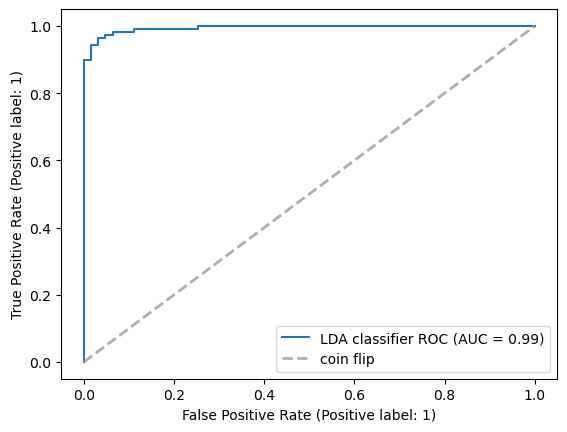

In [47]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve # deprecated
from sklearn.metrics import RocCurveDisplay

# Accuracy and ROC AUC curve for LDA
LDA_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LinearDiscriminantAnalysis(solver='eigen',
                                              tol=0.0006399999999999999,
                                              store_covariance=True,
                                              covariance_estimator=None))
])

LDA_pipe.fit(X_train, y_train)

y_pred = LDA_pipe.predict(X_test)

print("accuracy for LinearDiscriminantAnalysis:", accuracy_score(y_test, y_pred))
print("f1-score for LinearDiscriminantAnalysis:", f1_score(y_test, y_pred))


fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
   LDA_pipe, X_test, y_test, name="LDA classifier ROC", ax=ax)

# plot coin flip
ax.plot([0,1], [0,1], linestyle="--", lw=2, color=(0.6, 0.6, 0.6), label='coin flip', alpha=0.8)
plt.legend() # this was a lucky guess :)
plt.show()

For Logistic Regresssion not all penalties can be used for all solvers so need to break out 300 to 200, 50, 25, 25 and with valid pairings.

See: [Warning The choice of the algorithm depends on the penalty chosen: Supported penalties by solver: ...](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Also see: The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'

**Note:** There were `ConvergenceWarning` with the default `max_iter=100`.  For sake of time I did not increase this.  These warnings have been suppressed in the HTML output.

Additional Warnings suppressed:

    - UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
    - LineSearchWarning: The line search algorithm did not converge

In [56]:
# LogisticRegression Randomized
from scipy.stats import uniform
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# C (Inverse of regularization strength) float, default=1.0
# tol float, default=1e-4
# Algorithm to use in the optimization problem. Default is ‘lbfgs’.

# For LR 
# 200
params1 = dict(C=uniform(loc=0, scale=4), 
              penalty=['l2', 'none'],
              tol=np.linspace(1e-5, 1e-3, 100),
              solver=['newton-cg', 'lbfgs', 'sag', 'saga']
    )
# 50
params2 = dict(C=uniform(loc=0, scale=4), 
              penalty=['l1'],
              tol=np.linspace(1e-5, 1e-3, 100),
              solver=['liblinear', 'saga']
    )
# 25; 0 <= l1_ratio <= 1
params3 = dict(C=uniform(loc=0, scale=4), 
              penalty=['elasticnet'],
              tol=np.linspace(1e-5, 1e-3, 100),
              solver=['saga'],
              l1_ratio=np.linspace(0, 1, 6)
    )
# 25; need to also include l2 for liblinear
params4 = dict(C=uniform(loc=0, scale=4), 
              penalty=['l2'],
              tol=np.linspace(1e-5, 1e-3, 100),
              solver=['liblinear']
    )

lr_clf1 = RandomizedSearchCV(LogisticRegression(), params1, cv=5, random_state=0, n_iter=200, scoring='f1', error_score='raise')
search_lr1 = lr_clf1.fit(X_train, y_train)
print(search_lr1.best_params_)

lr_clf2 = RandomizedSearchCV(LogisticRegression(), params2, cv=5, random_state=0, n_iter=50, scoring='f1', error_score='raise')
search_lr2 = lr_clf2.fit(X_train, y_train)
print(search_lr2.best_params_)

lr_clf3 = RandomizedSearchCV(LogisticRegression(), params3, cv=5, random_state=0, n_iter=25, scoring='f1', error_score='raise')
search_lr3 = lr_clf3.fit(X_train, y_train)
print(search_lr3.best_params_)

lr_clf4 = RandomizedSearchCV(LogisticRegression(), params4, cv=5, random_state=0, n_iter=25, scoring='f1', error_score='raise')
search_lr4 = lr_clf4.fit(X_train, y_train)
print(search_lr4.best_params_)

{'C': 3.861664882079708, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.00062}
{'C': 3.9534953522369047, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.00047999999999999996}
{'C': 2.195254015709299, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.00065}
{'C': 2.115579679011618, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.00089}


In [11]:
scores_list = [search_lr1.cv_results_['mean_test_score'],
               search_lr2.cv_results_['mean_test_score'],
               search_lr3.cv_results_['mean_test_score'],
               search_lr4.cv_results_['mean_test_score']]
scores_flat = [item for sublist in scores_list for item in sublist]
print(len(scores_flat))
params_list = [search_lr1.cv_results_['params'],
               search_lr2.cv_results_['params'],
               search_lr3.cv_results_['params'],
               search_lr4.cv_results_['params']]
params_flat = [item for sublist in params_list for item in sublist]
print(len(params_flat))

# Get top 5 results from random LR
res = sorted(zip(scores_flat, params_flat), 
             key = lambda x: x[0],
             reverse=True)
res[0:5]

300
300


[(0.9642602273670235,
  {'C': 3.9534953522369047,
   'penalty': 'l1',
   'solver': 'liblinear',
   'tol': 0.00047999999999999996}),
 (0.9641874752866493,
  {'C': 3.861664882079708,
   'penalty': 'l2',
   'solver': 'newton-cg',
   'tol': 0.00062}),
 (0.9641874752866493,
  {'C': 3.586186383404252,
   'penalty': 'l2',
   'solver': 'newton-cg',
   'tol': 0.00035999999999999997}),
 (0.9641874752866493,
  {'C': 3.776479003670254,
   'penalty': 'l2',
   'solver': 'newton-cg',
   'tol': 0.00062}),
 (0.9641874752866493,
  {'C': 3.7655108188259945,
   'penalty': 'l2',
   'solver': 'newton-cg',
   'tol': 0.0005})]

In [12]:
# LR GridSearch
LR_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression())
])

#'solver': 'newton-cg' penalty [‘l2’, ‘none’] # only l2 in top
# Set tol, C from min to max with 5 values
paramsLR_newton_cg = dict(classifier__C=np.linspace(3.586186383404252, 3.861664882079708, 5), 
              classifier__penalty=['l2'],
              classifier__tol=np.linspace(0.00035999999999999997, 0.00062, 5),
              classifier__solver=['newton-cg']
    )

#'solver': ‘liblinear’ - [‘l1’, ‘l2’] # only liblinear is once in top so will do both
# Set tol, C from min to max with 5 values
paramsLR_liblinear = dict(classifier__C=np.linspace(3.9534953522369047-0.5, 3.9534953522369047-0.5, 5), 
              classifier__penalty=['l1','l2'],
              # cannot be negative but want to get the best one, 0.000479 in also
              classifier__tol=np.linspace(0.00047999999999999996-0.00047999999999999996+.0000001, 
                                          0.00047999999999999996+0.00047999999999999996, 5),
              classifier__solver=['liblinear']
    )

grid_LR_newton_cg = GridSearchCV(LR_pipe, param_grid=paramsLR_newton_cg, cv=kfold, n_jobs=4, 
                                 verbose=0, scoring='f1', error_score='raise')
grid_LR_newton_cg.fit(X_train, y_train)

grid_LR_liblinear = GridSearchCV(LR_pipe, param_grid=paramsLR_liblinear, cv=kfold, n_jobs=4, 
                                 verbose=0, scoring='f1', error_score='raise')
grid_LR_liblinear.fit(X_train, y_train)

## what are best params for LogisticRegression? get `f1` score on the test data
print("grid_LR_newton_cg", grid_LR_newton_cg.score(X_test, y_test))
print("grid_LR_newton_cg", grid_LR_newton_cg.best_score_)
print("grid_LR_newton_cg", grid_LR_newton_cg.best_params_)
print()

print("grid_LR_liblinear", grid_LR_liblinear.score(X_test, y_test))
print("grid_LR_liblinear", grid_LR_liblinear.best_score_)
print("grid_LR_liblinear", grid_LR_liblinear.best_params_)

grid_LR_newton_cg 0.986046511627907
grid_LR_newton_cg 0.9722186217343032
grid_LR_newton_cg {'classifier__C': 3.586186383404252, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg', 'classifier__tol': 0.00035999999999999997}

grid_LR_liblinear 0.986046511627907
grid_LR_liblinear 0.9722186217343032
grid_LR_liblinear {'classifier__C': 3.4534953522369047, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'classifier__tol': 1e-07}


98.6% on the test data.  Better than best score on training of 97.2%.  Best params were tied:

`paramsLR = dict(classifier__C=3.586186383404252, 
              classifier__penalty='l2', 
              classifier__solver='newton-cg', 
              classifier__tol=0.00035999999999999997)`

or

`paramsLR = dict(classifier__C=3.4534953522369047,
              classifier__penalty='l2', 
              classifier__solver='liblinear',
              classifier__tol=1e-07)`

accuracy for LogisticRegression: 0.9824561403508771
f1-score for LogisticRegression: 0.986046511627907


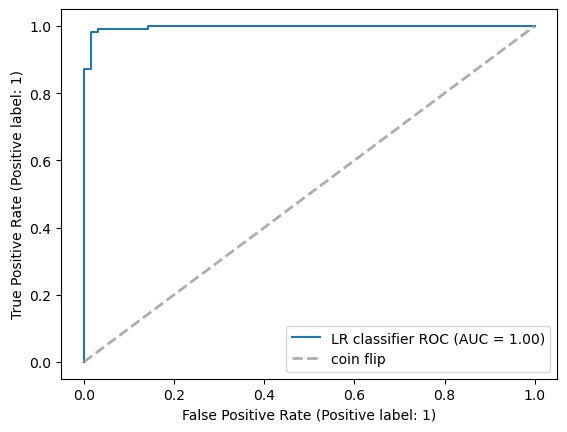

In [13]:
# Accuracy and ROC AUC curve for LR
LR_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(C=3.586186383404252, 
                                      penalty='l2', 
                                      solver='newton-cg', 
                                      tol=0.00035999999999999997))
])

LR_pipe.fit(X_train, y_train)

y_pred = LR_pipe.predict(X_test)

print("accuracy for LogisticRegression:", accuracy_score(y_test, y_pred))
print("f1-score for LogisticRegression:", f1_score(y_test, y_pred))

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
   LR_pipe, X_test, y_test, name="LR classifier ROC", ax=ax)

# plot coin flip
ax.plot([0,1], [0,1], linestyle="--", lw=2, color=(0.6, 0.6, 0.6), label='coin flip', alpha=0.8)
plt.legend() # this was a lucky guess :)
plt.show()

Support-Vector Machine Classifier

**Note:** SVC takes a while to run without limiting the max number of iterations and so I limited to 5000 max iterations.  This will throw `ConvergenceWarning` which I noticed and therefore ran StandardScaler even for the Randomized parameter search.  These warnings have been suppressed in the HTML output.

In [ ]:
# SVC Randomized

# C (Regularization parameter) float, default=1.0
# tol float, default=1e-3
# skipping cache size since it's small dataset
# decision_function_shape ovr=ovo with 2 states

# For SVC
# kernel='precomputed'can only be used when passing a (n_samples, n_samples) data matrix
params = dict(C=uniform(loc=0, scale=4), 
               gamma=['scale', 'auto'],
               degree=np.linspace(2, 8, 7),
               shrinking=[True, False],
               tol=np.linspace(1e-4, 1e-2, 100),
               class_weight=[None, 'balanced'],
               kernel=['linear', 'poly', 'rbf', 'sigmoid']
    )

# /Users/brian/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

svc_clf = RandomizedSearchCV(SVC(max_iter=5000), params, cv=5, random_state=0, n_iter=10, scoring='f1', error_score='raise')
search_svc = svc_clf.fit(X_train_scaled, y_train)
print(search_svc.best_params_)

In [15]:
# Get top 5 results from Randomized SVC
res = sorted(zip(search_svc.cv_results_['mean_test_score'], search_svc.cv_results_['params']), 
             key = lambda x: x[0],
             reverse=True)
res[0:5]

[(0.9820099980586294,
  {'C': 0.07515920174542057,
   'class_weight': 'balanced',
   'degree': 7.0,
   'gamma': 'scale',
   'kernel': 'linear',
   'shrinking': True,
   'tol': 0.0018000000000000002}),
 (0.9801160586646901,
  {'C': 2.4942547871438894,
   'class_weight': None,
   'degree': 6.0,
   'gamma': 'auto',
   'kernel': 'rbf',
   'shrinking': True,
   'tol': 0.0089}),
 (0.9759572192513369,
  {'C': 1.0582224484185079,
   'class_weight': 'balanced',
   'degree': 4.0,
   'gamma': 'auto',
   'kernel': 'linear',
   'shrinking': True,
   'tol': 0.0001}),
 (0.967672269267743,
  {'C': 0.5734131496361856,
   'class_weight': 'balanced',
   'degree': 2.0,
   'gamma': 'auto',
   'kernel': 'rbf',
   'shrinking': True,
   'tol': 0.0024}),
 (0.9479772328511824,
  {'C': 3.330479382191752,
   'class_weight': None,
   'degree': 2.0,
   'gamma': 'scale',
   'kernel': 'sigmoid',
   'shrinking': True,
   'tol': 0.005})]

In [39]:
# SVC GridSearch
SVC_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', SVC(max_iter=5000))
])

# no degree since `poly` not in top 5
paramsSVC = dict(classifier__C=np.linspace(0.07515920174542057, 3.330479382191752, 10), 
               classifier__gamma=['scale', 'auto'],
               classifier__shrinking=[True, False],
               classifier__tol=np.linspace(0.0001, 0.0089, 10),
               classifier__class_weight=[None, 'balanced'],
               classifier__kernel=['linear', 'rbf', 'sigmoid']
    )


grid_SVC = GridSearchCV(SVC_pipe, param_grid=paramsSVC, cv=kfold, n_jobs=1, verbose=0, scoring='f1')
grid_SVC.fit(X_train, y_train)

## what are best params for SVC? get `f1` score on the test data
print(grid_SVC.score(X_test, y_test))
print(grid_SVC.best_score_)
print(grid_SVC.best_params_)

0.986046511627907
0.9820861219474318
{'classifier__C': 0.07515920174542057, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'classifier__shrinking': True, 'classifier__tol': 0.001077777777777778}


98.6% on the test data.  Better than best score on training of 98.2%.  Best params were:

`paramsSVC = dict(classifier__C=0.07515920174542057, 
              classifier__class_weight='balanced', 
              classifier__gamma='scale', 
              classifier__kernel='linear', 
              classifier__shrinking=True,
              classifier__tol=0.001077777777777778)`



accuracy for SVC: 0.9824561403508771
f1-score for SVC: 0.986046511627907


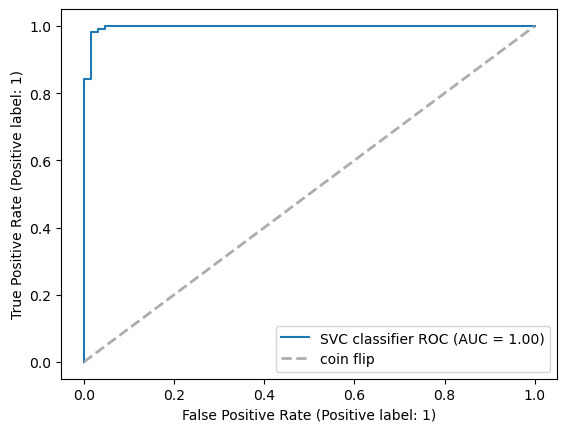

In [17]:
# Accuracy and ROC AUC curve for SVC best model
SVC_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', SVC(probability=True,
                       C=0.07515920174542057, 
                       class_weight='balanced',
                       gamma='scale',
                       kernel='linear',
                       shrinking=True,
                       tol=0.001077777777777778))
])

SVC_pipe.fit(X_train, y_train)

y_pred = SVC_pipe.predict(X_test)

print("accuracy for SVC:", accuracy_score(y_test, y_pred))
print("f1-score for SVC:", f1_score(y_test, y_pred))


fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(
   SVC_pipe, X_test, y_test, name="SVC classifier ROC", ax=ax)

# plot coin flip
ax.plot([0,1], [0,1], linestyle="--", lw=2, color=(0.6, 0.6, 0.6), label='coin flip', alpha=0.8)
plt.legend()
plt.show()

Same accurracy and f1-score between LR and SVC...

In [18]:
# EXTremely RAndomized (EXTRA) trees Randomized

# min_samples_split must be > 2 ??
# For EXTRA
params = dict(max_features=['sqrt','log2',None], 
              min_impurity_decrease=np.linspace(0.0, 5.0, 100),
              max_depth=np.arange(1, 30, dtype=int),
              n_estimators=range(10,500,10),
              criterion=['gini', 'entropy', 'log_loss'],
              min_samples_split=range(2,10,10),
              min_samples_leaf=range(1,10,10),
              class_weight=['balanced', 'balanced_subsample', None]
    )

# ValueError: The dual coefficients or intercepts are not finite. The input data may contain large values and need to bepreprocessed.
# Use standardard scaler from SVC above: X_train_scaled = scaler.transform(X_train)

EXTRA_clf = RandomizedSearchCV(ExtraTreesClassifier(), params, cv=5, random_state=0, n_iter=300, scoring='f1', error_score='raise')
search_EXTRA = EXTRA_clf.fit(X_train, y_train)
print(search_EXTRA.best_params_)

{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_features': None, 'max_depth': 19, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [19]:
# Get top 5 results from EXTRA trees
res = sorted(zip(search_EXTRA.cv_results_['mean_test_score'], search_EXTRA.cv_results_['params']), 
             key = lambda x: x[0],
             reverse=True)
res[0:5]

[(0.9702558726460883,
  {'n_estimators': 140,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'min_impurity_decrease': 0.0,
   'max_features': None,
   'max_depth': 19,
   'criterion': 'entropy',
   'class_weight': 'balanced'}),
 (0.9660978097809781,
  {'n_estimators': 320,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'min_impurity_decrease': 0.0,
   'max_features': 'sqrt',
   'max_depth': 7,
   'criterion': 'log_loss',
   'class_weight': 'balanced_subsample'}),
 (0.9557049701331565,
  {'n_estimators': 190,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'min_impurity_decrease': 0.050505050505050504,
   'max_features': 'log2',
   'max_depth': 20,
   'criterion': 'gini',
   'class_weight': 'balanced_subsample'}),
 (0.9528807974272606,
  {'n_estimators': 190,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'min_impurity_decrease': 0.050505050505050504,
   'max_features': None,
   'max_depth': 13,
   'criterion': 'gini',
   'class_weight': None}),
 (0.95

In [57]:
# EXTRA trees GridSearch 
EXTRA_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', ExtraTreesClassifier())
])


paramsEXTRA = dict(classifier__n_estimators=[100,140,210,320,450,480], 
               classifier__min_samples_split=[2],
               classifier__min_samples_leaf=[1],
               classifier__min_impurity_decrease=np.linspace(0.0, 0.30303030303030304, 5),
               classifier__max_features=[None, 'sqrt'],
               classifier__max_depth=[1,7,11,19,25],
               classifier__criterion=['gini', 'entropy', 'log_loss'],
               classifier__class_weight=['balanced', 'balanced_subsample']
    )


grid_EXTRA = GridSearchCV(EXTRA_pipe, param_grid=paramsEXTRA, cv=kfold, n_jobs=16, verbose=1, scoring='f1', error_score='raise')
grid_EXTRA.fit(X_train, y_train)

## what are best params for SVC? get `f1` score on the test data
print(grid_EXTRA.score(X_test, y_test))
print(grid_EXTRA.best_score_)
print(grid_EXTRA.best_params_)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
0.981651376146789
0.976232844388138
{'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 19, 'classifier__max_features': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 480}


In [21]:
print(grid_EXTRA.score(X_test, y_test))
print(grid_EXTRA.best_score_)
print(grid_EXTRA.best_params_)

0.981651376146789
0.9763910259672455
{'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 19, 'classifier__max_features': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


98.16% on the test data.  Better than best score on training of 98.02%.  Best params were:

`{'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'entropy', 'classifier__max_depth': 25, 'classifier__max_features': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 140}`

accuracy for ExtraTreesClassifier: 0.9766081871345029
f1-score for ExtraTreesClassifier: 0.981651376146789


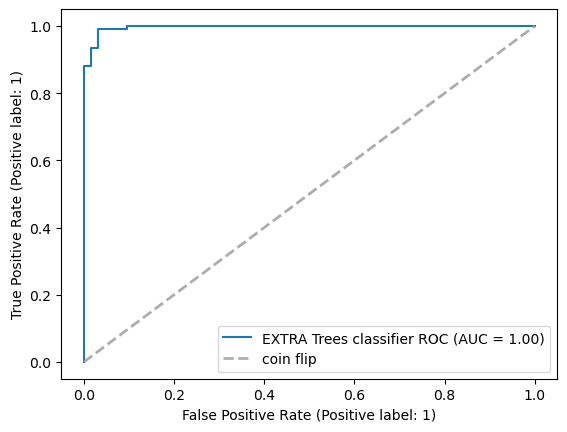

In [22]:
# Accuracy and ROC AUC curve for EXTRA trees
EXTRA_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', ExtraTreesClassifier(class_weight='balanced_subsample', 
                                        criterion='entropy',
                                        max_depth=25,
                                        max_features=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        n_estimators=140))
])

EXTRA_pipe.fit(X_train, y_train)

y_pred = EXTRA_pipe.predict(X_test)

print("accuracy for ExtraTreesClassifier:", accuracy_score(y_test, y_pred))
print("f1-score for ExtraTreesClassifier:", f1_score(y_test, y_pred))


fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
   EXTRA_pipe, X_test, y_test, name="EXTRA Trees classifier ROC", ax=ax)

# plot coin flip
ax.plot([0,1], [0,1], linestyle="--", lw=2, color=(0.6, 0.6, 0.6), label='coin flip', alpha=0.8)
plt.legend()
plt.show()

In [61]:
# XGB Random search
import xgboost as xgb

params_xgb = {'n_estimators': range(100,1000,20),
             'max_depth': np.arange(1, 30, dtype=int),
             'learning_rate': np.linspace(0.001,0.3,num=50),
             'reg_alpha': np.linspace(0.001,0.5,num=50)}

xboost = xgb.XGBClassifier()

xgb_clf = RandomizedSearchCV(xboost, params_xgb, cv=5, random_state=0, n_iter=300, scoring='f1',
                             error_score='raise', verbose=1)
search_xgb = xgb_clf.fit(X_train, y_train)
print(search_xgb.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'reg_alpha': 0.06210204081632653, 'n_estimators': 720, 'max_depth': 14, 'learning_rate': 0.2023673469387755}


In [24]:
# Get top 5 results from Randomized XGB
res = sorted(zip(search_xgb.cv_results_['mean_test_score'], search_xgb.cv_results_['params']), 
             key = lambda x: x[0],
             reverse=True)
print(len(res))
res[0:5]

300


[(0.978097033232735,
  {'reg_alpha': 0.06210204081632653,
   'n_estimators': 720,
   'max_depth': 14,
   'learning_rate': 0.2023673469387755}),
 (0.978097033232735,
  {'reg_alpha': 0.08246938775510204,
   'n_estimators': 800,
   'max_depth': 9,
   'learning_rate': 0.11693877551020407}),
 (0.978097033232735,
  {'reg_alpha': 0.16393877551020408,
   'n_estimators': 940,
   'max_depth': 3,
   'learning_rate': 0.22677551020408163}),
 (0.978097033232735,
  {'reg_alpha': 0.12320408163265306,
   'n_estimators': 700,
   'max_depth': 12,
   'learning_rate': 0.27559183673469384}),
 (0.978097033232735,
  {'reg_alpha': 0.06210204081632653,
   'n_estimators': 620,
   'max_depth': 11,
   'learning_rate': 0.2023673469387755})]

In [58]:
# XGB GridSearch 
XGB_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', xgb.XGBClassifier())
])


paramsXGB = dict(classifier__n_estimators=[620,700,720,800,940], 
               classifier__max_depth=[3,9,11,12,14],
               classifier__learning_rate=np.linspace(0.11693877551020407, 0.27559183673469384, 5), 
               classifier__reg_alpha=np.linspace(0.06210204081632653, 0.16393877551020408, 5),
    )
# paramsXGB = dict(classifier__n_estimators=[620,], 
#                classifier__max_depth=[3,6],
#                classifier__learning_rate=np.linspace(0.11693877551020407, 0.27559183673469384, 2), 
#                classifier__reg_alpha=np.linspace(0.06210204081632653, 0.16393877551020408, 2),
#     )


grid_XGB = GridSearchCV(XGB_pipe, param_grid=paramsXGB, cv=kfold, n_jobs=1, 
                        verbose=1, scoring='f1', error_score='raise')
grid_XGB.fit(X_train, y_train)

## what are best params for SVC? get `f1` score on the test data
print(grid_XGB.score(X_test, y_test))
print(grid_XGB.best_score_)
print(grid_XGB.best_params_)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
0.986046511627907
0.9759515687463104
{'classifier__learning_rate': 0.1566020408163265, 'classifier__max_depth': 3, 'classifier__n_estimators': 620, 'classifier__reg_alpha': 0.16393877551020408}


98.6% on the test data.  Better than best score on training of 97.6%.  Best params were:

`{'classifier__learning_rate': 0.1566020408163265, 'classifier__max_depth': 3, 'classifier__n_estimators': 620, 'classifier__reg_alpha': 0.16393877551020408}`

accuracy for XGB: 0.9824561403508771
f1-score for XGB: 0.986046511627907


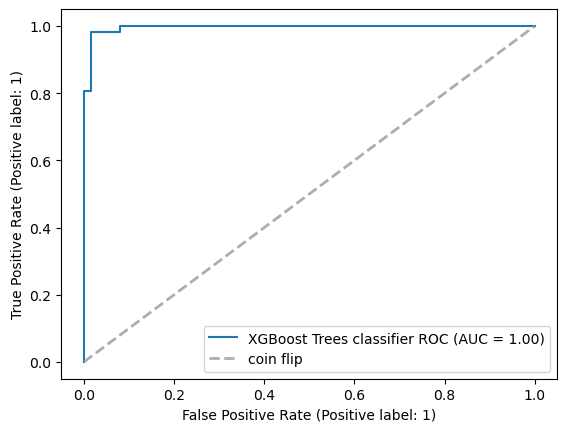

In [26]:
# Accuracy and ROC AUC curve for XGBoost
XGB_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', xgb.XGBClassifier(learning_rate=0.1566020408163265,
                                     max_depth=3,
                                     n_estimators=620,
                                     reg_alpha=0.16393877551020408))
])

XGB_pipe.fit(X_train, y_train)

y_pred = XGB_pipe.predict(X_test)

print("accuracy for XGB:", accuracy_score(y_test, y_pred))
print("f1-score for XGB:", f1_score(y_test, y_pred))


fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
   XGB_pipe, X_test, y_test, name="XGBoost Trees classifier ROC", ax=ax)

# plot coin flip
ax.plot([0,1], [0,1], linestyle="--", lw=2, color=(0.6, 0.6, 0.6), label='coin flip', alpha=0.8)
plt.legend()
plt.show()

Input the final best models of
your 5 classifiers using the mlxtend package to the second level classifiers, voting
classifier and stacking classifier. For the stacking classifier use the logistic regression as a
meta-classifier with the default parameters. Calculate the accuracy, the f1 score, and the
ROC AUC score for the initial 5 best models and the 2 second-level classifiers and
comment on the results.

In [37]:
# MLextend Voting Classifier (probably similar to sklearn.ensemble.VotingClassifier)
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

clf_LDA_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LinearDiscriminantAnalysis(solver='eigen',
                                      tol=0.00031999999999999997,
                                      store_covariance=True,
                                      covariance_estimator=None))
])

clf_LR_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(C=3.586186383404252, 
                                      penalty='l2', 
                                      solver='newton-cg', 
                                      tol=0.00035999999999999997))
])

clf_SVC_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', SVC(probability=True,
                       C=0.07515920174542057, 
                       class_weight='balanced',
                       gamma='scale',
                       kernel='linear',
                       shrinking=True,
                       tol=0.001077777777777778))
])

clf_EXTRA_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', ExtraTreesClassifier(class_weight='balanced_subsample', 
                                        criterion='entropy',
                                        max_depth=25,
                                        max_features=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        n_estimators=140))
])

clf_XGB_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', xgb.XGBClassifier(learning_rate=0.1566020408163265,
                                     max_depth=3,
                                     n_estimators=620,
                                     reg_alpha=0.16393877551020408))
])



# do Soft first with uniform weights; Uses uniform weights if None
# In multi-label classification, this is the subset accuracy
#     which is a harsh metric since you require for each sample that
#     each label set be correctly predicted.
eclf = EnsembleVoteClassifier(clfs=[clf_LDA_pipe, clf_LR_pipe, clf_SVC_pipe, clf_EXTRA_pipe, clf_XGB_pipe], 
                              voting='soft', weights = [1,5,5,3,3])
eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)

print("accuracy for EnsembleVoteClassifier, voting='soft':", accuracy_score(y_test, y_pred))
print("f1-score for EnsembleVoteClassifier, voting='soft':", f1_score(y_test, y_pred))
print()


# hard next with weights LR,SVC,XGB > EXTRA > LDA 
eclf_hard = EnsembleVoteClassifier(clfs=[clf_LDA_pipe, clf_LR_pipe, clf_SVC_pipe, clf_EXTRA_pipe, clf_XGB_pipe], 
                              voting='hard', weights = [1,5,5,3,5])
eclf_hard.fit(X_train, y_train)
y_pred = eclf_hard.predict(X_test)

print("accuracy for EnsembleVoteClassifier, voting='hard' + weights:", accuracy_score(y_test, y_pred))
print("f1-score for EnsembleVoteClassifier, voting='hard' + weights:", f1_score(y_test, y_pred))
print()

# hard next without weights
eclf_hard = EnsembleVoteClassifier(clfs=[clf_LDA_pipe, clf_LR_pipe, clf_SVC_pipe, clf_EXTRA_pipe, clf_XGB_pipe], 
                              voting='hard')
eclf_hard.fit(X_train, y_train)
y_pred = eclf_hard.predict(X_test)

print("accuracy for EnsembleVoteClassifier, voting='hard':", accuracy_score(y_test, y_pred))
print("f1-score for EnsembleVoteClassifier, voting='hard':", f1_score(y_test, y_pred))

accuracy for EnsembleVoteClassifier, voting='soft': 0.9766081871345029
f1-score for EnsembleVoteClassifier, voting='soft': 0.9814814814814815

accuracy for EnsembleVoteClassifier, voting='hard' + weights: 0.9824561403508771
f1-score for EnsembleVoteClassifier, voting='hard' + weights: 0.986046511627907

accuracy for EnsembleVoteClassifier, voting='hard': 0.9883040935672515
f1-score for EnsembleVoteClassifier, voting='hard': 0.9907407407407407


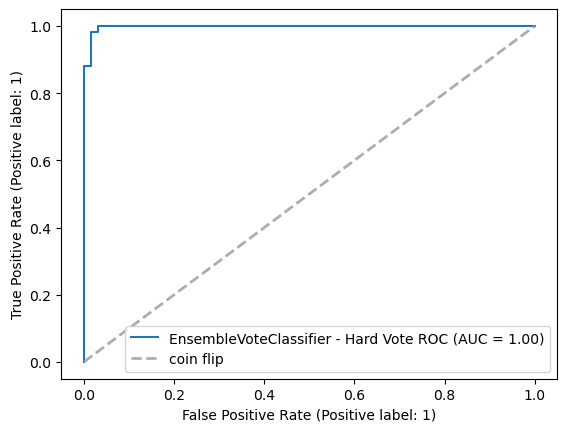

In [34]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(
   eclf, X_test, y_test, name="EnsembleVoteClassifier - Hard Vote ROC", ax=ax)

# plot coin flip
ax.plot([0,1], [0,1], linestyle="--", lw=2, color=(0.6, 0.6, 0.6), label='coin flip', alpha=0.8)
plt.legend()
plt.show()
blue = ax.get_lines()[0].get_color() # which color blue?

EnsembleVoteClassifier doesn't get any better accurracy than that of LR, SVC, or XGB at 0.9824561403508771 accurracy.

In [30]:
from mlxtend.classifier import StackingClassifier

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingClassifier(classifiers=[clf_LDA_pipe, clf_LR_pipe, clf_SVC_pipe, clf_EXTRA_pipe, clf_XGB_pipe],
                          meta_classifier=LogisticRegression())

sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)

print("accuracy for StackingClassifier, voting='hard':", accuracy_score(y_test, y_pred))
print("f1-score for StackingClassifier, voting='hard':", f1_score(y_test, y_pred))


accuracy for StackingClassifier, voting='hard': 0.9883040935672515
f1-score for StackingClassifier, voting='hard': 0.9907407407407407


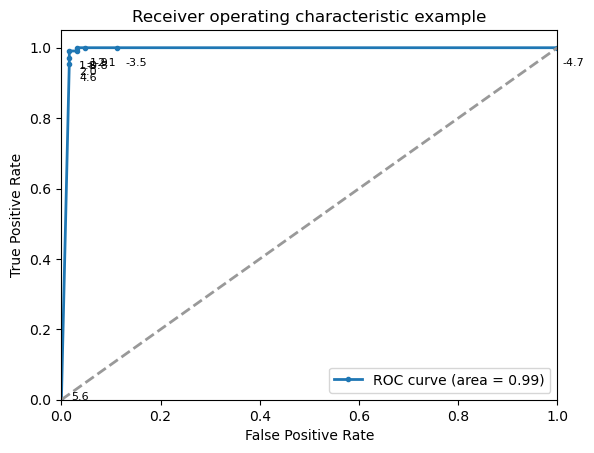

True

In [32]:
from sklearn.metrics import roc_curve, auc

def annot_thresh(thresh, x, y):
    plt.annotate('%0.1f' % thresh, xy=(x, y), xytext=(.99*x+.02, .95*y), fontsize=8)
    
y_score = sclf.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
area = auc(fpr, tpr)

# same as in my Machine Learning course https://github.com/BJWiley233/Practical-Computer-Concepts-Files/blob/master/Python/Machine%20Learning/Assignment_4_BrianWiley.ipynb
threshold_labels = np.around(thresholds, 2)
# fpr_100, tpr_100 = fpr[0::100], tpr[0::100]

plt.figure()
plt.plot(fpr, tpr, color=blue,
         lw=2, marker='.', label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

for i, thresh in enumerate(threshold_labels):
    annot_thresh(thresh, fpr[i], tpr[i])


plt.show()

# Sanity check to confirm sklearn sorts the thresholds from largest to smallest.
all(sorted(thresholds, reverse=True)[:10] == thresholds[:10])

#### Overall results from each 5 classifiers:
1. LinearDiscriminantAnalysis
    - Performed worst with accuracy 95.32% and f1-score of 96.36%
2. LosgisticRegression
    - As indicated running parameter hypertuning is a little more complicated with respect to the solvers and the penalty/regularization terms.  Not all solvers support all penalties
    - Was tied for first with both Support-Vector and X-Gradient Boosting classifiers
    - Performed best with accuracy 98.25% and f1-score of 98.6%
3. SVC
    - See above for LosgisticRegression
4. ExtraTreesClassifier
    - Performed second worst with accuracy 97.66% and f1-score of 98.17%
5. X-Gradient Boosting
    - See above for LosgisticRegression



#### Secondary Classifiers
The EnsembleVoteClassifier with soft voting performed worse than just Logistic Regression, Support-Vector Machines, or XGBoost alone but not much worse.  Hard voting with weights for best three being higher and LDA being lowest weight was equal for both accurracy and f1-score to Logistic Regression, Support-Vector Machines, and XGBoost (See above for LosgisticRegression accuracy and f1-score.  Without weights the accuracy and f1-score were better and equaled exactly to the accurracy and f1-score of 98.83% and 99.07% respectively.  
